In [ ]:
import os
import math
# import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn import preprocessing


%matplotlib inline

#ETL
The raw data file is separated by **::** without headers. This part is transforming the raw data file into a CSV with headers, which can be easily imported using Pandas in the following parts. All the user and movie id will be subtracted by 1 for zero-based index. 

## Extract

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2022-09-14 11:04:34--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  27.8MB/s    in 0.2s    

2022-09-14 11:04:35 (27.8 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [ ]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


## Transform

In [ ]:
BASE_DIR = '/content'
MOVIELENS_DIR = os.path.join(BASE_DIR, 'ml-1m')

USERS_DATA_FILE = 'users.dat'
MOVIES_DATA_FILE = 'movies.dat'
RATINGS_DATA_FILE = 'ratings.dat'

RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'

### Ratings data

In [ ]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATINGS_DATA_FILE),
                      sep='::',
                      engine='python',
                      encoding='latin-1',
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])


In [ ]:
max_user_id = ratings['user_id'].drop_duplicates().max()
max_movie_id = ratings['movie_id'].drop_duplicates().max()

In [ ]:
ratings['new_user_id'] = ratings['user_id'] - 1
ratings['new_movie_id'] = ratings['movie_id'] - 1

print(f"{len(ratings)} ratings loaded")

ratings.to_csv(RATINGS_CSV_FILE,
               sep='\t',
               header=True,
               encoding='latin',
               columns=['new_user_id', 'new_movie_id', 'rating', 'timestamp'])

print(f"Saved to {RATINGS_CSV_FILE}")

1000209 ratings loaded
Saved to ml1m_ratings.csv


### User-related data

In [ ]:
# reference: http://files.grouplens.org/datasets/movielens/ml-1m-README.txt
AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 
        50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 
               3: "clerical/admin", 4: "college/grad student", 5: "customer service", 
               6: "doctor/health care", 7: "executive/managerial", 8: "farmer", 
               9: "homemaker", 10: "K-12 student", 11: "lawyer",12: "programmer", 
               13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
               17: "technician/engineer", 18: "tradesman/craftsman", 
               19: "unemployed", 20: "writer" }

In [ ]:
users = pd.read_csv(os.path.join(MOVIELENS_DIR, USERS_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'gender', 'age', 'occupation', 'zipcode'])

users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])

print(len(users), 'descriptions of', max_user_id, 'users loaded.')

users['user_emb_id'] = users['userid'] - 1

users.to_csv(USERS_CSV_FILE, 
             sep='\t', 
             header=True, 
             encoding='latin-1',
             columns=['user_emb_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])

print('Saved to', USERS_CSV_FILE)

6040 descriptions of 6040 users loaded.
Saved to ml1m_users.csv


## Load

In [ ]:
df = pd.read_csv(RATINGS_CSV_FILE, sep='\t', encoding='latin-1',
                 usecols=['new_user_id', 'new_movie_id', 'rating', 'timestamp'])
df.head()

,new_user_id,new_movie_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [ ]:
df.tail()

,new_user_id,new_movie_id,rating,timestamp
1000204,6039,1090,1,956716541
1000205,6039,1093,5,956704887
1000206,6039,561,5,956704746
1000207,6039,1095,4,956715648
1000208,6039,1096,4,956715569


#Preprocessing

## Label encode

In [ ]:
le_user = preprocessing.LabelEncoder()
df.loc[:, 'new_user_id'] = le_user.fit_transform(df['new_user_id'].values)

le_item = preprocessing.LabelEncoder()
df.loc[:, 'new_movie_id'] = le_item.fit_transform(df['new_movie_id'].values)

In [ ]:
num_users = df['new_user_id'].nunique()
num_movies = df['new_movie_id'].nunique()

(num_users, num_movies)

(6040, 3706)

## Train/val/test split
We split the data into random 90%–10% train-test sets, and hold out 10% of the training set for validation.

In [ ]:
train_df, test_df = train_test_split(df,
                                     stratify=df['new_user_id'],
                                     test_size=0.1,
                                     random_state=42)

Using **stratify** with **user_id** is critical; without this setting, it's possible that reviews of one user are all split into either the training or test set and cause bias. For example if all the reviews of user A are put into the training set, then during test time, there is no test data for this user. The test RMSE will be 0 for this user. On the other hand, if all reviews are put into test set, then there is no review for this user during training time and cause the RMSE higher for this user.

In [ ]:
train_df, val_df = train_test_split(train_df,
                                    stratify=train_df['new_user_id'],
                                    test_size=0.1,
                                    random_state=42)

In [ ]:
(train_df.shape, val_df.shape, test_df.shape)

((810169, 4), (90019, 4), (100021, 4))

## Creating the user-item interaction matrix, with users in rows and items in columns
In order to apply **AutoRec** on the dataset, the dataset should be transformed to a MxN matrix where R(i, j) is the ratings given by the i<sup>th</sup> user to the j<sup>th</sup> item. The function ```dataPreprocessor``` is used for this transformation. The ```init_value``` is the default rating for unobserved ratings.

In [ ]:
def dataPreprocessor(ratings_df, num_users, num_items, init_value=0.0, 
                     average=False):
    if not average:
        matrix = np.full((num_users, num_items), init_value)
        for (_, user_id, movie_id, rating, _) in ratings_df.itertuples():
            matrix[user_id, movie_id] = rating
    else:
        matrix = np.full((num_users, num_items), 0.0)
        for(_, user_id, movie_id, rating, _) in ratings_df.itertuples():
            matrix[user_id, movie_id] = rating
        avg_user_rating = matrix.sum(axis=1) / np.maximum((matrix!=0).sum(axis=1), 1)
        unobserved_entries = np.where(matrix==0)
        matrix[unobserved_entries] = np.take(avg_user_rating, 
                                             unobserved_entries[0])
        
        

    return matrix

In [ ]:
user_item_matrix_train = dataPreprocessor(train_df, num_users, num_movies)

user_item_matrix_train_avg = dataPreprocessor(train_df, num_users, num_movies, 
                                             average=True)
user_item_matrix_val = dataPreprocessor(val_df, num_users, num_movies)
user_item_matrix_test = dataPreprocessor(test_df, num_users, num_movies)

# Custom Loss Function

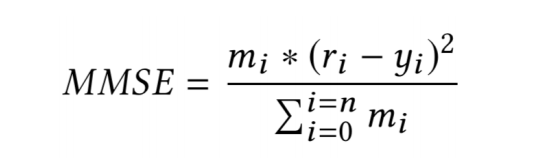

where r<sub>i</sub> is the actual rating and y<sub>i</sub> is the reconstructed rating. m<sub>i</sub> is a mask function where m<sub>i</sub> =1 where  r<sub>i</sub> is non-zero else m<sub>i</sub>=0.

In [ ]:
def masked_mse(y_true, y_pred):
    
    mask_true = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)

    y_true, y_pred = tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)
    
    masked_square_error = tf.math.square(mask_true * (y_true - y_pred))
    masked_mse = tf.math.reduce_sum(masked_square_error, axis=-1) / \
                tf.maximum(tf.math.reduce_sum(mask_true, axis=-1), 1)
    
    return masked_mse


The performance of the model is measured by the Masked Root Mean Squared Error (MRMSE). Similar to MMSE, we only take into consideration the error where the rating is not zero in the test set. Also, clipping the predicted rating with 1 as minimum and 5 as maximum.

In [ ]:
def masked_rmse_clip(y_true, y_pred):
    
    mask_true = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)

    y_true, y_pred = tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)

    y_pred = tf.clip_by_value(y_pred, clip_value_min=1, clip_value_max=5)
    
    masked_square_error = tf.math.square(mask_true * (y_true - y_pred))
    masked_mse = tf.math.reduce_sum(masked_square_error, axis=-1) / \
                tf.maximum(tf.math.reduce_sum(mask_true, axis=-1), 1)
    
    return tf.math.sqrt(masked_mse)

# AutoRec

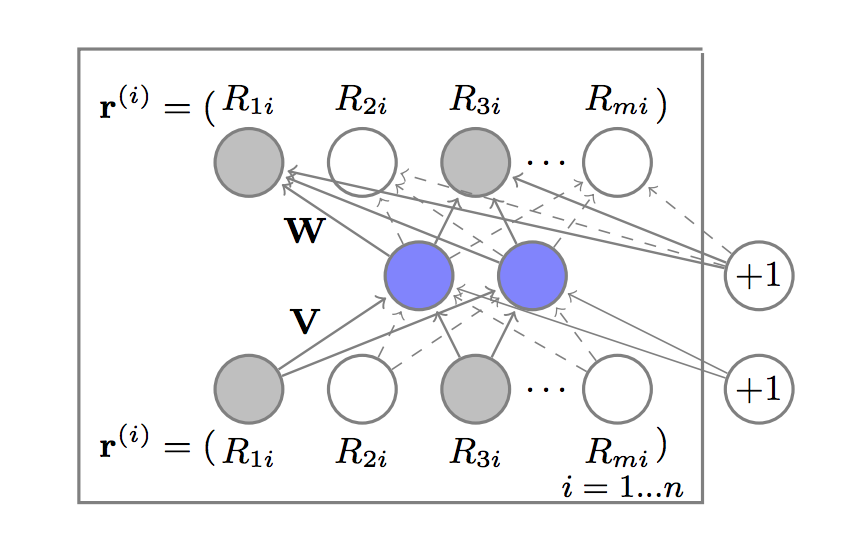

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
def AutoRec(X, reg, first_act, last_act, dropout):
    '''
    AutoRec
        INPUT: 
          X: #_user x #_item matrix
          reg: L2 regularization parameter
          first_act: activation function for first dense layer
          last_act: activation function for second dense layer
        
        OUTPUT:
          Keras model
    
    '''
    input_layer = tf.keras.Input(shape=(X.shape[1],), name='UserRating')


    x = Dense(500, activation=first_act, name='LatentSpace',
              kernel_regularizer=regularizers.l2(reg))(input_layer)

    x = tf.keras.layers.Dropout(dropout)(x)

    output_layer = Dense(X.shape[1], activation=last_act, name='UserScorePred', 
                         kernel_regularizer=regularizers.l2(reg))(x)

    model = tf.keras.Model(input_layer, output_layer)

    return model

In [ ]:
def AutoRec_LReLU(X, reg, dropout):
    '''
    AutoRec
        LReLu is not implemented in to Dense 
            Need to have seperate LeakyRelu layer 
    '''
    input_layer = tf.keras.Input(shape=(X.shape[1],), name='UserRating')

    x = Dense(500, name='LatentSpace', 
              kernel_regularizer=regularizers.l2(reg))(input_layer)

    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Dropout(dropout)(x)

    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred',
                         kernel_regularizer=regularizers.l2(reg))(x)

    model = tf.keras.Model(input_layer, output_layer)

    return model

In [ ]:
model_1 = AutoRec(user_item_matrix_train, 0.001, 'elu', 'elu', 0.2)
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss=masked_mse, 
                metrics=[masked_rmse_clip])
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3706)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1853500   
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 UserScorePred (Dense)       (None, 3706)              1856706   
                                                                 
Total params: 3,710,206
Trainable params: 3,710,206
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_AutoRec = model_1.fit(x=user_item_matrix_train_avg, y=user_item_matrix_train,
                           epochs=500,
                           batch_size=256,
                           verbose=2,
                           validation_data=[user_item_matrix_train_avg, user_item_matrix_val]
                           )

Epoch 1/500
24/24 - 1s - loss: 8.9022 - masked_rmse_clip: 2.0353 - val_loss: 4.3556 - val_masked_rmse_clip: 1.3864 - 1s/epoch - 45ms/step
Epoch 2/500
24/24 - 0s - loss: 4.2736 - masked_rmse_clip: 1.4556 - val_loss: 2.7814 - val_masked_rmse_clip: 0.9911 - 339ms/epoch - 14ms/step
Epoch 3/500
24/24 - 0s - loss: 3.2629 - masked_rmse_clip: 1.2246 - val_loss: 2.5874 - val_masked_rmse_clip: 0.9350 - 303ms/epoch - 13ms/step
Epoch 4/500
24/24 - 0s - loss: 2.9965 - masked_rmse_clip: 1.1516 - val_loss: 2.5108 - val_masked_rmse_clip: 0.9203 - 295ms/epoch - 12ms/step
Epoch 5/500
24/24 - 0s - loss: 2.8443 - masked_rmse_clip: 1.1111 - val_loss: 2.4616 - val_masked_rmse_clip: 0.9180 - 298ms/epoch - 12ms/step
Epoch 6/500
24/24 - 0s - loss: 2.7406 - masked_rmse_clip: 1.0856 - val_loss: 2.4141 - val_masked_rmse_clip: 0.9133 - 290ms/epoch - 12ms/step
Epoch 7/500
24/24 - 0s - loss: 2.6595 - masked_rmse_clip: 1.0683 - val_loss: 2.3718 - val_masked_rmse_clip: 0.9108 - 277ms/epoch - 12ms/step
Epoch 8/500
24/2

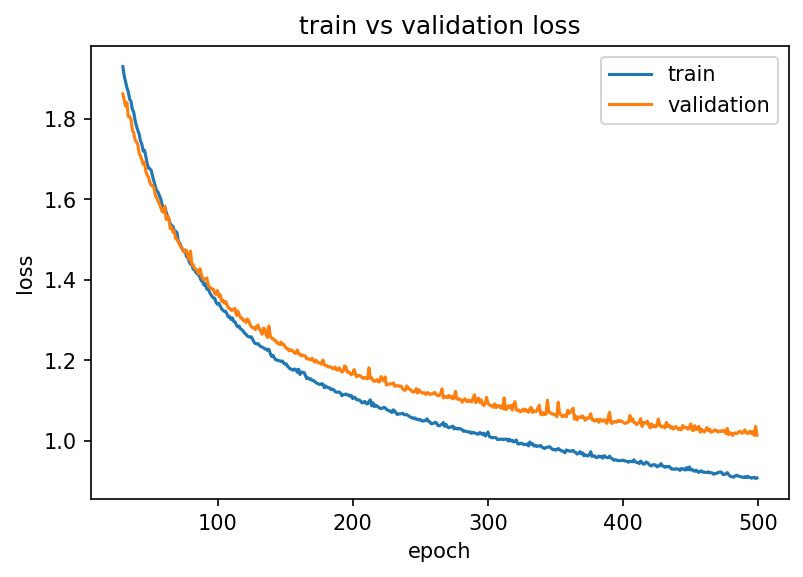

In [ ]:
show_error(hist_AutoRec, 30)

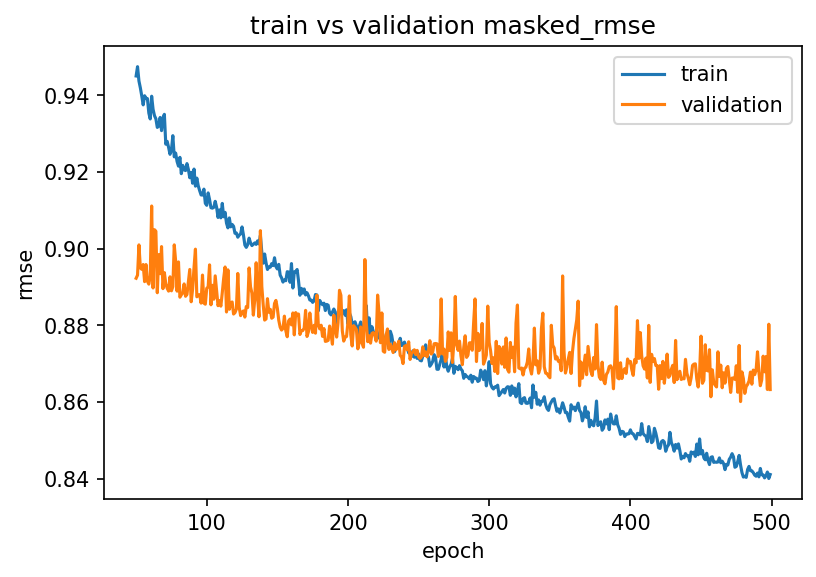

In [ ]:
show_rmse(hist_AutoRec, 50)

In [ ]:
test_result = model_1.evaluate(user_item_matrix_train_avg, user_item_matrix_test)
print(test_result)

189/189 [==============================] - 1s 3ms/step - loss: 1.0287 - masked_rmse_clip: 0.8731
[1.0286953449249268, 0.8730604648590088]


# Util functions

## Plots

In [ ]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.plot(np.arange(skip, len(loss)), loss[skip:])
    plt.plot(np.arange(skip, len(loss)), val_loss[skip:])
    plt.title('train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.gcf().set_dpi(150)
    plt.show()

In [ ]:
def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    
    plt.plot(np.arange(skip, len(rmse)), rmse[skip:])
    plt.plot(np.arange(skip, len(rmse)), val_rmse[skip:])
    plt.title('train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.gcf().set_dpi(150)
    plt.show()

## Save and Load Model

In [ ]:
def load_model(name):
    # load json and create model
    with open(f"{name}.json", 'r') as model_file:
        loaded_model_json = model_file.read()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(f"{name}.h5")
    print("Loaded model from disk")
    return loaded_model

In [ ]:
def save_model(name, model):
    # serialize model to json
    model_json = model.to_json()
    with open(f"{name}.json", 'w') as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights("{name}.h5")
    print("Saved model to disk")

# Model Plots

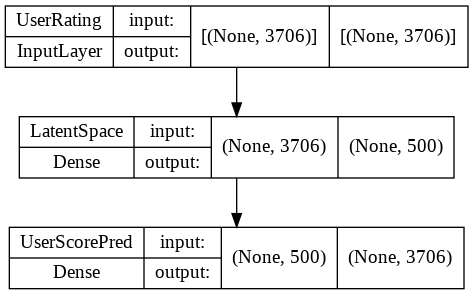

In [ ]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

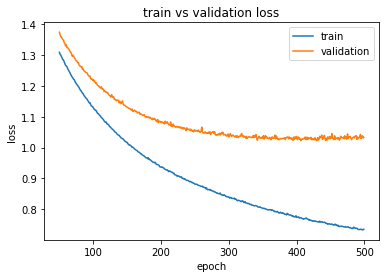

In [ ]:
show_error(hist_AutoRec, 50)

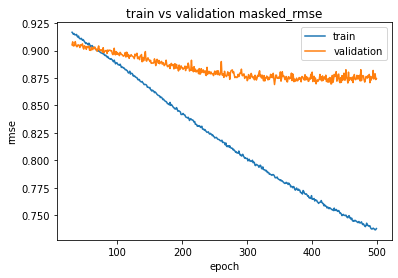

In [ ]:
show_rmse(hist_AutoRec, 30)

In [ ]:
model_2 = AutoRec_LReLU(user_item_matrix_train, 0.1)
model_2.compile(optimizer=Adam(learning_rate=0.001), loss=masked_mse, 
                metrics=[masked_rmse_clip])
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3706)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1853500   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 500)               0         
                                                                 
 UserScorePred (Dense)       (None, 3706)              1856706   
                                                                 
Total params: 3,710,206
Trainable params: 3,710,206
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
hist_2 = model_2.fit(x=user_item_matrix_train, y=user_item_matrix_train,
                           epochs=500,
                           batch_size=256,
                           verbose=2,
                           validation_data=[user_item_matrix_train, user_item_matrix_val]
                           )

Epoch 1/500
24/24 - 1s - loss: 86.4299 - masked_rmse_clip: 2.4329 - val_loss: 22.4673 - val_masked_rmse_clip: 2.0782 - 1s/epoch - 57ms/step
Epoch 2/500
24/24 - 0s - loss: 11.8485 - masked_rmse_clip: 1.9960 - val_loss: 7.5774 - val_masked_rmse_clip: 1.9281 - 472ms/epoch - 20ms/step
Epoch 3/500
24/24 - 0s - loss: 7.1141 - masked_rmse_clip: 1.9162 - val_loss: 6.7831 - val_masked_rmse_clip: 1.8931 - 470ms/epoch - 20ms/step
Epoch 4/500
24/24 - 0s - loss: 6.6255 - masked_rmse_clip: 1.8920 - val_loss: 6.5026 - val_masked_rmse_clip: 1.8616 - 473ms/epoch - 20ms/step
Epoch 5/500
24/24 - 0s - loss: 6.4286 - masked_rmse_clip: 1.8700 - val_loss: 6.3477 - val_masked_rmse_clip: 1.8472 - 454ms/epoch - 19ms/step
Epoch 6/500
24/24 - 0s - loss: 6.2826 - masked_rmse_clip: 1.8540 - val_loss: 6.1862 - val_masked_rmse_clip: 1.8118 - 458ms/epoch - 19ms/step
Epoch 7/500
24/24 - 0s - loss: 6.2003 - masked_rmse_clip: 1.8412 - val_loss: 6.0953 - val_masked_rmse_clip: 1.7723 - 447ms/epoch - 19ms/step
Epoch 8/500
2

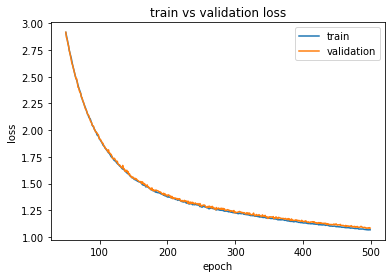

In [ ]:
show_error(hist_2, 50)

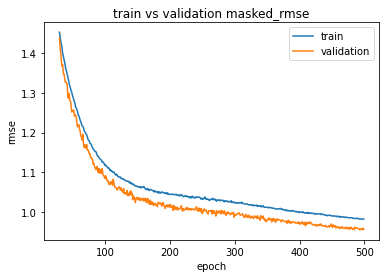

In [ ]:
show_rmse(hist_2, 30)

# Deep AutoRec

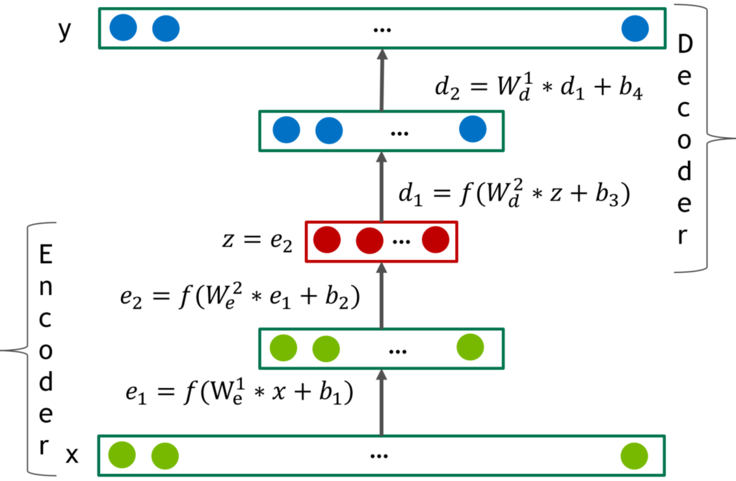

In [ ]:
def DeepAutoRec(X, layers, act, last_act, dropout, reg_enc, reg_dec, 
                side_info_size=0):
    """
    INPUT:
        X: user-item rating matrix, (#users, #items)
        layers: list containing no. of units for each Dense layer
        act: activation function for all dense layer except the last
        last_act: activation function for the last dense layer
        dropout: dropout rate
        reg_enc: L2 regularization parameter for encoder
        reg_dec: L2 regularization parameter for decoder
        side_info_size: size of the one hot encoded side information

    OUTPUT:
            DeepAutoRec model
    """
    # Input Layer
    input = x = tf.keras.layers.Input(shape=(X.shape[1],), name='UserRating')

    # Encoder
    n = int(len(layers) / 2)    # no. of layers in the encoder part
    i = 0

    for l in layers[:n]:
        x = Dense(l, activation=act, name=f"EncLayer_{i}", 
                  kernel_regularizer=regularizers.l2(reg_enc))(x)
        i += 1
    
    # Latent Space or bottleneck layer
    x = Dense(layers[n], activation=act, name='LatentSpace', 
              kernel_regularizer=regularizers.l2(reg_enc))(x)

    # Dropout
    x = tf.keras.layers.Dropout(dropout)(x)

    # Decoder
    j = 0
    for l in layers[n+1:]:
        x = Dense(l, activation=act, name=f"DecLayer_{j}",
                  kernel_regularizer=regularizers.l2(reg_dec))(x)
        j += 1
    
    # Output Layer
    output = x = Dense(X.shape[1]-side_info_size, activation=last_act, 
              name='UserScorePred', 
              kernel_regularizer=regularizers.l2(reg_dec))(x)

    model = tf.keras.Model(input, output)

    return model

In [ ]:
layers = [256, 512, 256]
layers_0 = [512, 1024, 512] 
layers_1 = [512, 256, 128, 256, 512]
layers_2 = [512, 256, 512]
layers_3 = [128, 256, 512, 256, 128]
layers_4 = [512, 512, 1024, 512, 512]

dropout = 0.8
act_1 = 'selu'
last_act_1 = 'selu'

act_2 = 'sigmoid'
last_act_2 = 'linear'

act_3 = 'relu'
last_act_3 = 'relu'

reg_enc = 0.001
reg_dec = 0.001

In [ ]:
deep_model = DeepAutoRec(user_item_matrix_train, layers, act_1, last_act_1,
                         dropout, reg_enc, reg_dec)
deep_model.compile(optimizer=Adam(lr=0.0001), loss=masked_mse, 
                   metrics=[masked_rmse_clip])
deep_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3706)]            0         
                                                                 
 EncLayer_0 (Dense)          (None, 256)               948992    
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer_0 (Dense)          (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3706)              952442    
                                                                 
Total params: 2,164,346
Trainable params: 2,164,346
Non-tra

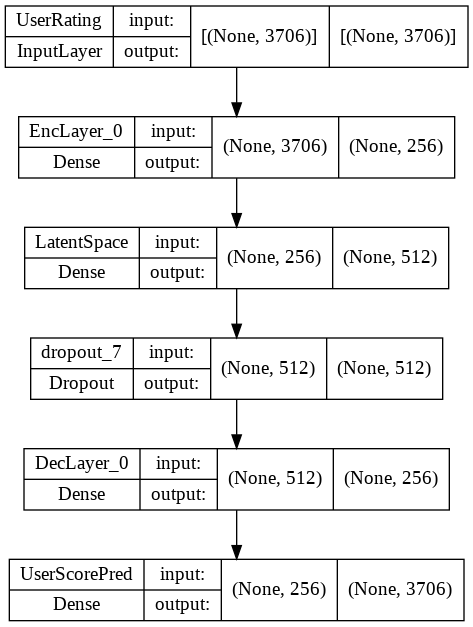

In [ ]:
tf.keras.utils.plot_model(deep_model, show_shapes=True)

In [ ]:
deep_history = deep_model.fit(x=user_item_matrix_train, y=user_item_matrix_train,
                              epochs=500,
                              batch_size=256,
                              validation_data=[user_item_matrix_train, user_item_matrix_val],
                              verbose=2)

Epoch 1/500
24/24 - 2s - loss: 16.2880 - masked_rmse_clip: 2.8549 - val_loss: 13.9329 - val_masked_rmse_clip: 2.8150 - 2s/epoch - 67ms/step
Epoch 2/500
24/24 - 0s - loss: 10.9941 - masked_rmse_clip: 2.4743 - val_loss: 6.5353 - val_masked_rmse_clip: 1.9212 - 301ms/epoch - 13ms/step
Epoch 3/500
24/24 - 0s - loss: 6.1011 - masked_rmse_clip: 1.8044 - val_loss: 3.8404 - val_masked_rmse_clip: 1.3718 - 301ms/epoch - 13ms/step
Epoch 4/500
24/24 - 0s - loss: 4.2308 - masked_rmse_clip: 1.4752 - val_loss: 3.0732 - val_masked_rmse_clip: 1.1439 - 299ms/epoch - 12ms/step
Epoch 5/500
24/24 - 0s - loss: 3.7178 - masked_rmse_clip: 1.3599 - val_loss: 2.8591 - val_masked_rmse_clip: 1.0776 - 290ms/epoch - 12ms/step
Epoch 6/500
24/24 - 0s - loss: 3.4988 - masked_rmse_clip: 1.3105 - val_loss: 2.7425 - val_masked_rmse_clip: 1.0409 - 281ms/epoch - 12ms/step
Epoch 7/500
24/24 - 0s - loss: 3.3673 - masked_rmse_clip: 1.2800 - val_loss: 2.6680 - val_masked_rmse_clip: 1.0207 - 289ms/epoch - 12ms/step
Epoch 8/500
2

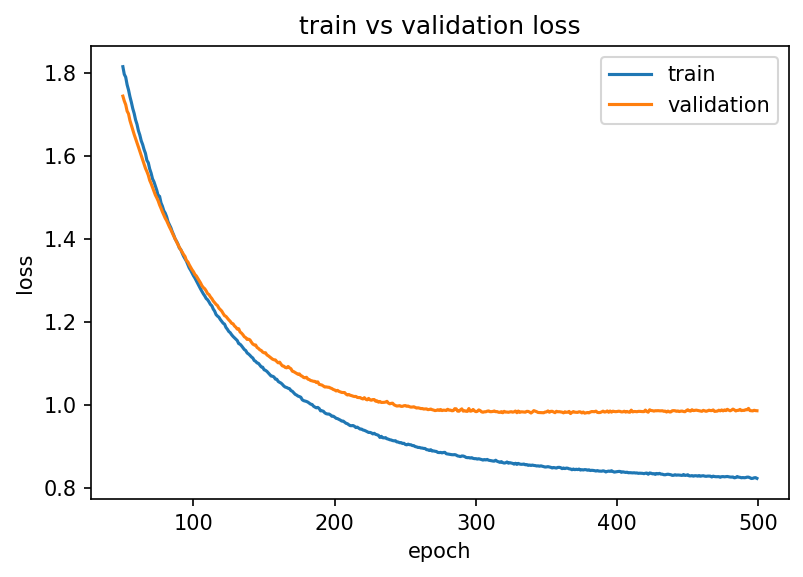

In [ ]:
show_error(deep_history, 50)

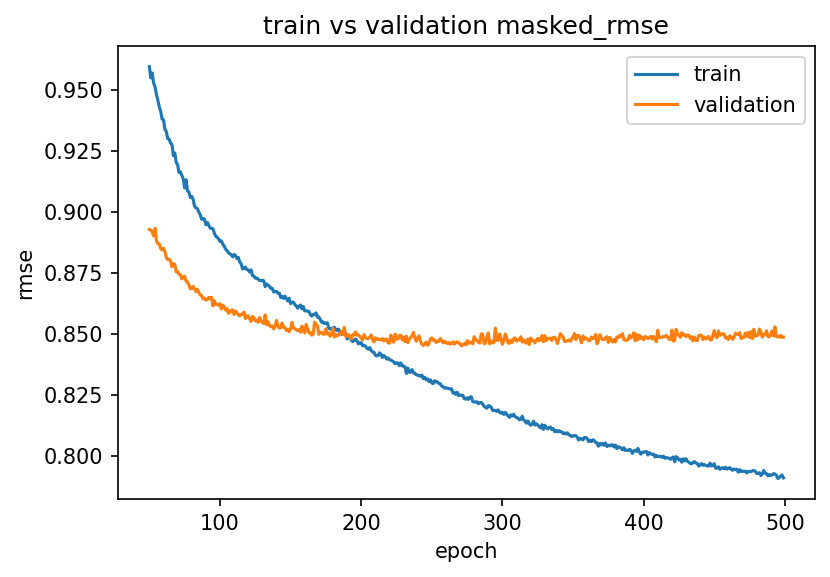

In [ ]:
show_rmse(deep_history, 50)

In [ ]:
test_result = deep_model.evaluate(user_item_matrix_train, user_item_matrix_test)
print(test_result)

189/189 [==============================] - 1s 3ms/step - loss: 0.9989 - masked_rmse_clip: 0.8577
[0.998897135257721, 0.8576850295066833]


## Hybrid approach with DeepRec

### Side-info. preprocessing

In [ ]:
user_df = pd.read_csv('ml1m_users.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'gender', 'age', 'occupation'])

user_df.head(5)

,user_emb_id,gender,age,occupation
0,0,F,1,10
1,1,M,56,16
2,2,M,25,15
3,3,M,45,7
4,4,M,25,20


In [ ]:
user_df['age'] = preprocessing.LabelEncoder().fit(user_df['age']).transform(user_df['age'])
user_df['gender'] = preprocessing.LabelEncoder().fit(user_df['gender']).transform(user_df['gender'])
onehot_df = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False).fit(user_df[['gender', 'age', 'occupation']]).transform(user_df[['gender', 'age', 'occupation']])

In [ ]:
onehot_df.shape

(6040, 30)

For each user, we have gender, age and occupation and after transforming to one hot encoding format, each user has total of 30 features.

### Concatenating side-info to input, while keeping output the same

In [ ]:
user_item_matrix_train.shape

(6040, 3706)

In [ ]:
user_item_matrix_with_user_info = np.concatenate((user_item_matrix_train, onehot_df), axis=1)

In [ ]:
user_item_matrix_with_user_info.shape

(6040, 3736)

For this method, we concatenated the side information to the rating matrix; so the shape of the matrix will be changed from 6040x3706 to 6040x3736.

### Model

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
# Build model
hybrid_deep_model = DeepAutoRec(user_item_matrix_with_user_info, layers, 
                               activation, last_activation, dropout, 
                               regularizer_encode, regularizer_decode, 30)
hybrid_deep_model.compile(optimizer = Adam(learning_rate=0.0001), 
                          loss=masked_mse, metrics=[masked_rmse_clip]) 
hybrid_deep_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3736)]            0         
                                                                 
 EncLayer_0 (Dense)          (None, 256)               956672    
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 DecLayer_0 (Dense)          (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3706)              952442    
                                                                 
Total params: 2,172,026
Trainable params: 2,172,026
Non-tr

In [ ]:
hist_hybrid = hybrid_deep_model.fit(x=user_item_matrix_with_user_info, 
                                    y=user_item_matrix_train,
                                    epochs=500,
                                    batch_size=256,
                  validation_data=[user_item_matrix_with_user_info, 
                                   user_item_matrix_val], 
                                    verbose=2)

Epoch 1/500
24/24 - 2s - loss: 16.3632 - masked_rmse_clip: 2.8587 - val_loss: 14.1613 - val_masked_rmse_clip: 2.8249 - 2s/epoch - 75ms/step
Epoch 2/500
24/24 - 0s - loss: 11.2091 - masked_rmse_clip: 2.4992 - val_loss: 6.6552 - val_masked_rmse_clip: 1.9499 - 399ms/epoch - 17ms/step
Epoch 3/500
24/24 - 1s - loss: 6.1522 - masked_rmse_clip: 1.8116 - val_loss: 3.8557 - val_masked_rmse_clip: 1.3794 - 548ms/epoch - 23ms/step
Epoch 4/500
24/24 - 0s - loss: 4.2146 - masked_rmse_clip: 1.4770 - val_loss: 3.0458 - val_masked_rmse_clip: 1.1367 - 418ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 3.6839 - masked_rmse_clip: 1.3535 - val_loss: 2.8219 - val_masked_rmse_clip: 1.0640 - 403ms/epoch - 17ms/step
Epoch 6/500
24/24 - 0s - loss: 3.4680 - masked_rmse_clip: 1.3040 - val_loss: 2.7160 - val_masked_rmse_clip: 1.0323 - 328ms/epoch - 14ms/step
Epoch 7/500
24/24 - 0s - loss: 3.3504 - masked_rmse_clip: 1.2762 - val_loss: 2.6438 - val_masked_rmse_clip: 1.0121 - 423ms/epoch - 18ms/step
Epoch 8/500
2

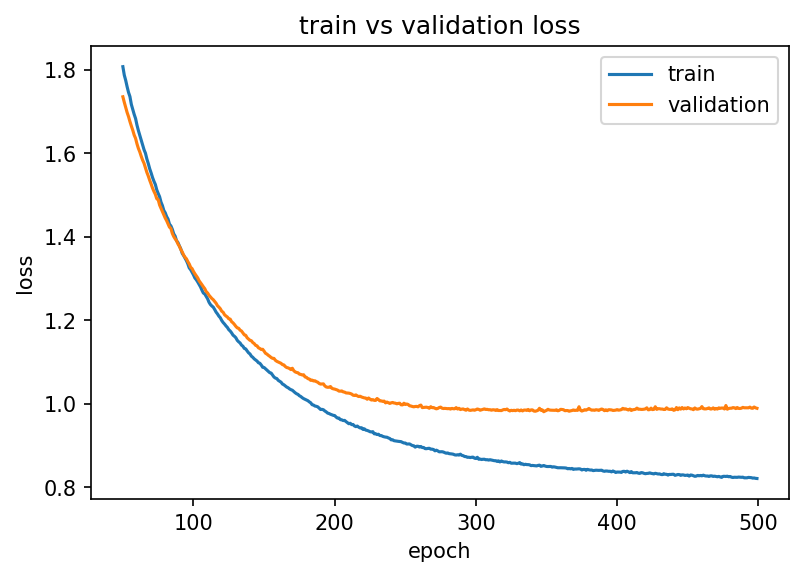

In [ ]:
show_error(hist_hybrid, 50)

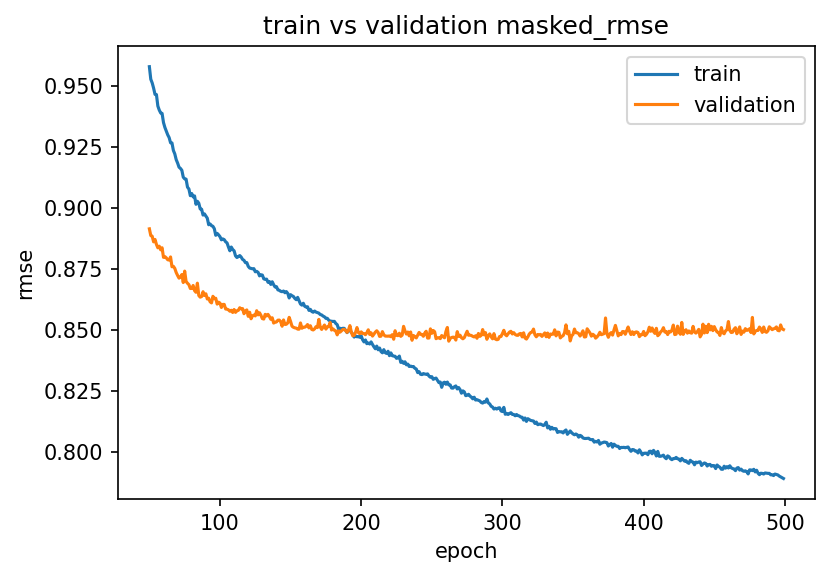

In [ ]:
show_rmse(hist_hybrid, 50)

In [ ]:
test_results = hybrid_deep_model.evaluate(user_item_matrix_with_user_info, 
                                          user_item_matrix_test)
print(test_result)

189/189 [==============================] - 1s 4ms/step - loss: 0.9987 - masked_rmse_clip: 0.8582
[0.998897135257721, 0.8576850295066833]
